### 📁 Dataset Dictionary

---

- `Review`: A written opinion provided by a customer about their experience in the Hotel.
- `Rating`: A numerical or star-based score given by a customer to reflect their level of satisfaction with the service.   

## Table of Contents

1. [Import Data](#1-import-data)  
2. [Feature Transformation](#2-feature-transformation)  
3. [Data Cleaning](#3-data-cleaning)  
4. [Stop Words Removal](#4-stop-words-removal)  
5. [Dataset Comparison](#5-dataset-comparison)  
6. [Class Balancing](#6-class-balancing)  
7. [Data Preprocessing](#7-data-preprocessing)  
8. [Baseline Modeling with LazyPredict](#8-baseline-modeling-with-lazypredict)  
9. [LGBMClassifier Training](#9-lgbmclassifier-training)  
10. [ExtraTreesClassifier Training](#10-extratreesclassifier-training)  
11. [Model Selection](#11-model-selection)  
12. [Deployment](#12-deployment)  

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Libraries
</div>

In [3]:
import re
import pickle
import nltk
import sklearn
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_iris
import warnings

In [4]:
%reload_ext watermark
%watermark -a "Nuno Leite"

Author: Nuno Leite



In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Import Data
</div>

In [7]:
# Load the dataset
df_trip = pd.read_csv(r"C:\Users\nuno_\Documents\PEN\RL DSBA\DSA\Tripadvisor\tripadvisor_hotel_reviews.csv")

In [8]:
# Shape
df_trip.shape

(20491, 2)

In [9]:
# Data sample
df_trip.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [10]:
# Info
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Feature Transformation 
</div>

This function maps numerical customer ratings (from 1 to 5) to sentiment categories. Ratings of 1 or 2 are labeled as 'unhappy', 3 as 'neutral', and 4 or 5 as 'happy'. This transformation simplifies the original rating scale into broader sentiment classes for use in sentiment analysis or classification models.

In [13]:
def map_sentiment(rating):
    if rating in [1, 2]:
        return 'unhappy'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'happy'

#Aply the function
df_trip['Sentiment'] = df_trip['Rating'].apply(map_sentiment)

#drop label Rating
df_trip = df_trip.drop('Rating', axis=1)

In [20]:
df_trip

,Review,Sentiment
0,nice hotel expensive parking got good deal sta...,happy
1,ok nothing special charge diamond member hilto...,unhappy
2,nice rooms not 4* experience hotel monaco seat...,neutral
3,"unique, great stay, wonderful time hotel monac...",happy
4,"great stay great stay, went seahawk game aweso...",happy
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",happy
20487,great location price view hotel great quick pl...,happy
20488,"ok just looks nice modern outside, desk staff ...",unhappy
20489,hotel theft ruined vacation hotel opened sept ...,unhappy


<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Data Cleaning 
</div>

We now transform the categorical labels into numerical values.

In [26]:
df_trip.Sentiment.replace('unhappy', 0, inplace = True)
df_trip.Sentiment.replace('neutral', 1, inplace = True)
df_trip.Sentiment.replace('happy', 2, inplace = True)

In [28]:
df_trip.head()

,Review,Sentiment
0,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",2
4,"great stay great stay, went seahawk game aweso...",2


In [30]:
# User Review
df_trip.Review[0] # First line

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

__`Function for general data cleaning`__

In [33]:
def data_cleaning(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

In [35]:
# Testing
text_with_special_caracters = "Hello, Nuno! How are You?"
text_cleaned = data_cleaning(text_with_special_caracters)
print(text_cleaned)

Hello  Nuno  How are You 


In [37]:
# Aply the function
df_trip.Review = df_trip.Review.apply(data_cleaning)

In [38]:
df_trip.Review[0] # First line

'nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking  check quick easy  little disappointed non existent view room room clean nice size  bed comfortable woke stiff neck high pillows  not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway  maybe just noisy neighbors  aveda bath products nice  did not goldfish stay nice touch taken advantage staying longer  location great walking distance shopping  overall nice experience having pay 40 parking night   '

__`Function to convert text to lowercase`__

In [40]:
def lower_convert(text):
    return text.lower()

In [44]:
# Testing
sentence = "This sentence cONtains CAPITAL LettERS"
correction = lower_convert(sentence)
print(correction)

this sentence contains capital letters


In [46]:
# Aply the function
df_trip.Review = df_trip.Review.apply(lower_convert)

In [48]:
df_trip.Review[0]

'nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking  check quick easy  little disappointed non existent view room room clean nice size  bed comfortable woke stiff neck high pillows  not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway  maybe just noisy neighbors  aveda bath products nice  did not goldfish stay nice touch taken advantage staying longer  location great walking distance shopping  overall nice experience having pay 40 parking night   '

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Remove Stop Words
</div>

__`Function to remove stopwords`__

In [52]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(str(text))
    return [w for w in words if w not in stop_words]

In [54]:
# Testing
sentence = "They are right, as this is exactly what happened with me"
correction = remove_stopwords(sentence)
print(correction)

['They', 'right', ',', 'exactly', 'happened']


In [56]:
%%time
df_trip.Review = df_trip.Review.apply(remove_stopwords)

CPU times: total: 9 s
Wall time: 9.05 s


In [57]:
df_trip.Review[0]

['nice',
 'hotel',
 'expensive',
 'parking',
 'got',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary',
 'arrived',
 'late',
 'evening',
 'took',
 'advice',
 'previous',
 'reviews',
 'valet',
 'parking',
 'check',
 'quick',
 'easy',
 'little',
 'disappointed',
 'non',
 'existent',
 'view',
 'room',
 'room',
 'clean',
 'nice',
 'size',
 'bed',
 'comfortable',
 'woke',
 'stiff',
 'neck',
 'high',
 'pillows',
 'soundproof',
 'like',
 'heard',
 'music',
 'room',
 'night',
 'morning',
 'loud',
 'bangs',
 'doors',
 'opening',
 'closing',
 'hear',
 'people',
 'talking',
 'hallway',
 'maybe',
 'noisy',
 'neighbors',
 'aveda',
 'bath',
 'products',
 'nice',
 'goldfish',
 'stay',
 'nice',
 'touch',
 'taken',
 'advantage',
 'staying',
 'longer',
 'location',
 'great',
 'walking',
 'distance',
 'shopping',
 'overall',
 'nice',
 'experience',
 'pay',
 '40',
 'parking',
 'night']

__`Function for Stemmer`__

In [59]:
def trip_stemmer(text):
    object_stemmer = SnowballStemmer('english') 
    return " ".join([object_stemmer.stem(w) for w in text])

In [60]:
# Testing
sentence = "The customer is enjoying the experience"
sentence_stemmed = trip_stemmer(sentence.split())
print(sentence_stemmed)

the custom is enjoy the experi


In [61]:
%%time
df_trip.Review = df_trip.Review.apply(trip_stemmer)

CPU times: total: 16.9 s
Wall time: 17 s


In [62]:
df_trip.Review[0]

'nice hotel expens park got good deal stay hotel anniversari arriv late even took advic previous review valet park check quick easi littl disappoint non exist view room room clean nice size bed comfort woke stiff neck high pillow soundproof like heard music room night morn loud bang door open close hear peopl talk hallway mayb noisi neighbor aveda bath product nice goldfish stay nice touch taken advantag stay longer locat great walk distanc shop overal nice experi pay 40 park night'

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Compare the datasets
</div>

The function pd.set_option('display.max_colwidth', 120) is used to increase the maximum number of characters shown for each cell in a pandas DataFrame when displaying text columns

In [65]:
pd.set_option('display.max_colwidth', 120)

In [66]:
original_data = pd.read_csv(r"C:\Users\nuno_\Documents\PEN\RL DSBA\DSA\Tripadvisor\tripadvisor_hotel_reviews.csv")

In [67]:
original_data.head(10)

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean sui...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet fr...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, ...",5
5,love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th...,5
6,"cozy stay rainy city, husband spent 7 nights monaco early january 2008. business trip chance come ride.we booked mon...",5
7,"excellent staff, housekeeping quality hotel chocked staff make feel home, experienced exceptional service desk staff...",4
8,"hotel stayed hotel monaco cruise, rooms generous decorated uniquely, hotel remodeled pacific bell building charm stu...",5
9,"excellent stayed hotel monaco past w/e delight, reception staff friendly professional room smart comfortable bed, pa...",5


In [68]:
df_trip.head(10)

,Review,Sentiment
0,nice hotel expens park got good deal stay hotel anniversari arriv late even took advic previous review valet park ch...,2
1,ok noth special charg diamond member hilton decid chain shot 20th anniversari seattl start book suit paid extra webs...,0
2,nice room 4 experi hotel monaco seattl good hotel n 4 level posit larg bathroom mediterranean suit comfort bed pillo...,1
3,uniqu great stay wonder time hotel monaco locat excel short stroll main downtown shop area pet friend room show sign...,2
4,great stay great stay went seahawk game awesom downfal view build n complain room huge staff help book hotel websit ...,2
5,love monaco staff husband stay hotel crazi weekend attend memori servic best friend husband celebr 12th wed annivers...,2
6,cozi stay raini citi husband spent 7 night monaco earli januari 2008 busi trip chanc come ride book mont carlo suit ...,2
7,excel staff housekeep qualiti hotel chock staff make feel home experienc except servic desk staff concierg door men ...,2
8,hotel stay hotel monaco cruis room generous decor uniqu hotel remodel pacif bell build charm sturdi everytim walk be...,2
9,excel stay hotel monaco past w e delight recept staff friend profession room smart comfort bed particular like recep...,2


In [73]:
# delete
del original_data

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Balacing Classes
</div>

In [75]:
# Generating random samples from the data
df_trip = df_trip.sample(n = len(df_trip))

In [76]:
# Adjust the dataset index
df_trip = df_trip.reset_index(drop = True)

In [77]:
# Create Index 
rows_happy = df_trip.Sentiment == 2
rows_neutral = df_trip.Sentiment == 1
rows_unhappy = df_trip.Sentiment == 0

In [78]:
# Set values for the index
df_trip_happy = df_trip.loc[rows_happy]
df_trip_neutral = df_trip.loc[rows_neutral]
df_trip_unhappy = df_trip.loc[rows_unhappy]


In [79]:
# Min Value
n = np.min([len(df_trip_happy), len(df_trip_neutral), len(df_trip_unhappy)])
print(n)

2184


In [80]:
# Obtain random values for the training dataset
df_trip_blc = pd.concat([df_trip_happy.sample(n = n, random_state = 64),
                            df_trip_neutral.sample(n = n, random_state = 64),
                            df_trip_unhappy.sample(n = n, random_state = 64)],
                           axis = 0,
                           ignore_index = True)


In [81]:
# Sampling
df_trip_blc = df_trip_blc.sample(n = len(df_trip_blc), random_state = 64).reset_index(drop = True)

In [82]:
balance = df_trip_blc['Sentiment'].value_counts(normalize=True) * 100
print("\nDistribuição das classes (em %):")
print(balance.round(2))


Distribuição das classes (em %):
Sentiment
0   33.33
2   33.33
1   33.33
Name: proportion, dtype: float64


In [83]:
df_trip_blc['Sentiment'].value_counts()

Sentiment
0    2184
2    2184
1    2184
Name: count, dtype: int64

In [100]:
pd.set_option('display.max_colwidth', None)

df_trip_blc.head(10)

,Review,Sentiment
0,avoid whitney moment check noth went right famili travel hotel gave wrong room suppos suit got room famili got room occupi walk coupl way bed park mighti incoveni time consum room shabbi none clean none incent write hotel cut busi new orlean lot slack day understaf n plenti staff treat guest care mess ice cake hotel slap 75 charg check earli refus remov n notic initial wrong date check form habit check calendar check hotel certain convers desk clerk day probabl leav day fact leav main point encount mistak hotel matter hotel employe deal mistak will assum respons attempt foist guest implicit accus guest dishonesti say whitney respons textbook exampl act go new orlean stay,0
1,nasti n wast time money site late pay stay room scari reserv lost 10 minut wait pull total nasti room cours apolog ask room told none cours charg credit card 1 night stay call speak manag got run lie downright nasti horribl peopl conflict falsehood shownmani room person initi reserv told cancel polici n work anymor unprofession scrambl new orlean dur busi time place clean stay upset 1 000 mile home,0
2,lack cleanli return trip old san juan stay hotel room comfort maid clean room stay night occas housekeep room suppos clean occas husband sat corridor watch maid room take fresh set towel car stand corridor went room spent 15 minut came went room disinfect glass cleaner clean class hand went left room taken soil towel wipe face basin class shelf touch tub dirti know clean cup glass room went housekeep call came examin room sent disinfect solut clean tub ask better complain cleanli room time appreci uniqu hotel ruin stay eat hotel cost outrag higher hawaii breakfast egg toast piec fruit 30 00 exampl tasteless appet hotel caf ä fruit cocktail 60 00,0
3,eh didnt like room hotel super small bathroom given bad room overlook dumpster floor eekk hate,0
4,thiev paradis date visit feb 8 2005 food good weather bad like big resort like bahia punta cana show even terribl staff speak littl english drink sunquest hacienda guest cheap liquor rum order bailey smirnoff lobbi bar charg 14 00 u drink list drink inclus packag trust noth heard caesar rum order bahia serv tomato clamato cloth person item stolen room paid 40 00 u check room safe skyservic charg overweight charg luggag leav punta cana came home toronto took left toiletri gift maid hotel staff luggag overweight embark trip toronto ontario canada idea weigh left pay overweight charg skyservic leav come home told plane skyservic toronto one know weigh luggag proper origin want 75 00 u request receipt skyservic got home sudden drop 25 00 u pay charg generous tip gift item stolen room theft item room disappoint told guest wast time report choos thought maid blame staff room repairmen report need repair mini bar fill daili 4 staff present sure total dominican 7 time time item stolen,0
5,winner madrid love madrid palac definit book room gorgeous stay floor 6 spg prefer guest room amex n happier room quiet peac retreat amid busi citi room look hotel court yard cut nois servic excel overal pleasant experi,2
6,kid love place famili spent week april 2004 husband kid age 3 9 mos time mother law stay 3bd 3ba villa 30 feet beach decor noth write home function layout common area connect 3 separ bedroom courtyard bit problemat small children open villa bit unsettl locat villa awesom privat beach yard mind best villa avail exclud ultra luxuri villa thing better updat kitchen truli seen better day close unit screen eaten aliv mosquito bedroom door open access kid beach love calm cabana loung chair perman umbrella fair easi big plus book food great lot option staff friend complet bilingu spa realli children husband fantast time golf cours love play quick sophisc place manag seemless servic slow end world lot famili singl coupl guest geograph divers nice complet surround folk northeast son fell love talk 6 year old daughter scuba instructor reason give pcr 4 3 base locat room wonder time kid bit rustic tast,2
7,good

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Data Pre-Processing
</div>

In [103]:
# Extracts the review text (input)
x = np.array(df_trip_blc.iloc[:,0].values)


In [105]:
# Extract the sentiment (output)
y = np.array(df_trip_blc.Sentiment.values)

__`Train Test Split`__

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 0)

In [110]:
type(x_train)

numpy.ndarray

__`Vectorizer creation`__

In [113]:
vectorizer_trip = CountVectorizer(max_features = 1000)

In [115]:
x_train_final = vectorizer_trip.fit_transform(x_train).toarray() # transform and aplly to traing data
x_test_final = vectorizer_trip.transform(x_test).toarray() # transform and aplly to test data

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Machine Learning Models with Lazypredict
</div>

In [137]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(x_train_final, x_test_final, y_train, y_test)

print(models)


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6177
[LightGBM] [Info] Number of data points in the train set: 5241, number of used features: 1000
[LightGBM] [Info] Start training from score -1.081586
[LightGBM] [Info] Start training from score -1.106081
[LightGBM] [Info] Start training from score -1.108391
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.71               0.71    None      0.71   
SVC                                0.70               0.70    None      0.70   
XGBClassifier                      0.70               0.70    None      0.70   
NuSVC                              0.69               0.69    None      0.69   
Extr

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
LGBMClassifier
</div>


In [117]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

__`Model 1`__

In [120]:
model_1 = LGBMClassifier()
model_1.fit(x_train_final, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5265
[LightGBM] [Info] Number of data points in the train set: 5896, number of used features: 1000
[LightGBM] [Info] Start training from score -1.094212
[LightGBM] [Info] Start training from score -1.097765
[LightGBM] [Info] Start training from score -1.103884


LGBMClassifier()

__`Hyperparameter Tuning with GridSearchCV`__

In [74]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]
}

estim = LGBMClassifier(verbosity=-1)

grid_search_lgbm = GridSearchCV(estimator=estim, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_lgbm.fit(x_train_final, y_train)

print("Best Hyperparameters for LGBMClassifier:")
print(grid_search_lgbm.best_params_)

print("Best Accuracy:", grid_search_lgbm.best_score_)

Best Hyperparameters for LGBMClassifier:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 15}
Best Accuracy: 0.7021581804553956


__`Model 2`__

In [124]:
model_2 = LGBMClassifier(
    learning_rate=0.05,
    max_depth=7,
    n_estimators=200,
    num_leaves=15
)
model_2.fit(x_train_final, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5265
[LightGBM] [Info] Number of data points in the train set: 5896, number of used features: 1000
[LightGBM] [Info] Start training from score -1.094212
[LightGBM] [Info] Start training from score -1.097765
[LightGBM] [Info] Start training from score -1.103884


LGBMClassifier(learning_rate=0.05, max_depth=7, n_estimators=200, num_leaves=15)

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
ExtraTreesClassifier
</div>




__`Model 3`__

In [126]:
from sklearn.ensemble import ExtraTreesClassifier

model_3 = ExtraTreesClassifier(
    n_estimators=100,        
    max_depth=None,         
    random_state=42         
)

model_3.fit(x_train_final, y_train)


ExtraTreesClassifier(random_state=42)

__`Hyperparameter Tuning with GridSearchCV`__

In [81]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

estim2 = ExtraTreesClassifier(random_state=42)

grid_search_ext = GridSearchCV(
    estimator=estim2,
    param_grid=param_grid,
    cv=5,                         
    scoring='accuracy',        
    n_jobs=-1,                    
    verbose=1
)

# Fit with the training data
grid_search_ext.fit(x_train_final, y_train)

print("Best Hyperparameter for extratreesClassifier:")
print(grid_search_ext.best_params_)

# Best accuracy
print("Best Accuracy:", grid_search_ext.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameter for extratreesClassifier:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Accuracy: 0.708834477037382


In [128]:
best_params2 = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'
}

model_4 = ExtraTreesClassifier(**best_params2, random_state=42)

model_4.fit(x_train_final, y_train)


ExtraTreesClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=300,
                     random_state=42)

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Select the best Model
</div>


In [130]:
def evaluate_model(model, x_test, y_test, title="Confusion Matrix"):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       210
           1       0.59      0.58      0.59       217
           2       0.79      0.83      0.81       229

    accuracy                           0.71       656
   macro avg       0.71      0.71      0.71       656
weighted avg       0.71      0.71      0.71       656



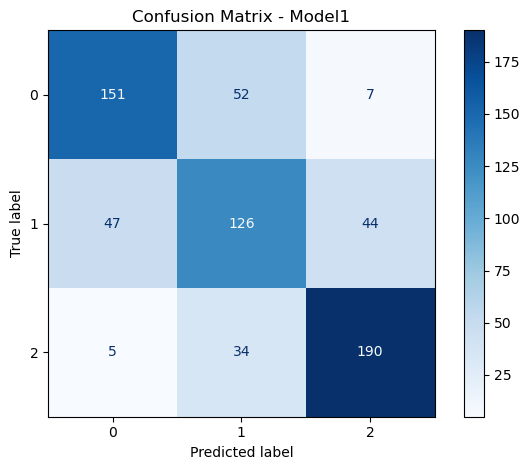

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       210
           1       0.59      0.59      0.59       217
           2       0.76      0.81      0.78       229

    accuracy                           0.70       656
   macro avg       0.70      0.70      0.70       656
weighted avg       0.70      0.70      0.70       656



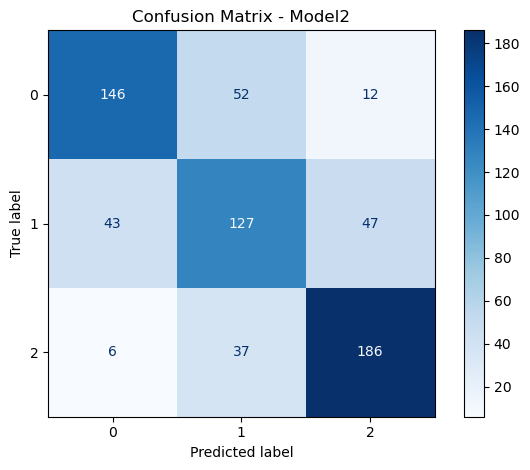

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       210
           1       0.60      0.58      0.59       217
           2       0.78      0.78      0.78       229

    accuracy                           0.71       656
   macro avg       0.71      0.71      0.71       656
weighted avg       0.71      0.71      0.71       656



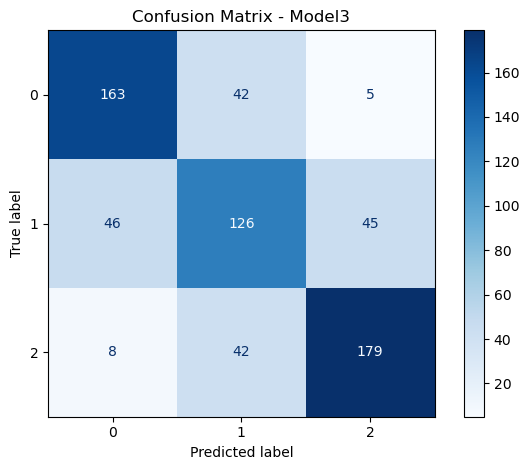

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       210
           1       0.65      0.52      0.57       217
           2       0.76      0.84      0.80       229

    accuracy                           0.72       656
   macro avg       0.71      0.72      0.71       656
weighted avg       0.71      0.72      0.71       656



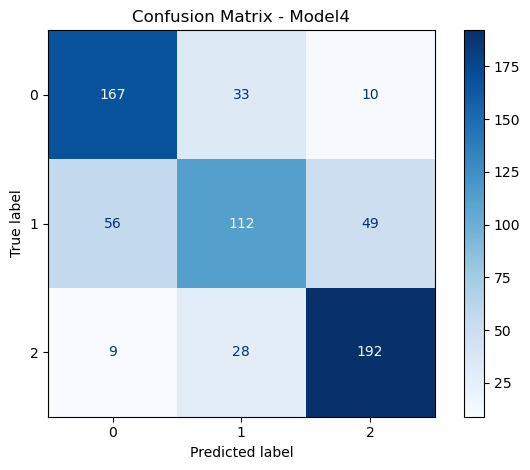

In [132]:
evaluate_model(model_1, x_test_final, y_test, title="Confusion Matrix - Model1")
evaluate_model(model_2, x_test_final, y_test, title="Confusion Matrix - Model2")
evaluate_model(model_3, x_test_final, y_test, title="Confusion Matrix - Model3")
evaluate_model(model_4, x_test_final, y_test, title="Confusion Matrix - Model4")

In [180]:
# Saving the best model

with open('model_4.pkl', 'wb') as file:
    pickle.dump(model_4, file)

<div style="background-color:#fefefe; padding:12px; border-left:6px solid #0984e3; font-weight:bold; font-size:16px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); transform: skewX(-1deg);">
Deploy
</div>

In [183]:
with open('model_4.pkl', 'rb') as file:
    final_model = pickle.load(file)

In [205]:
# Text from a user review (this text expresses a positive sentiment)

text_aval = """wow wow wow resort, just came honeymoon resort absolutly beautiful, drinks great food room service notch service,
nic cafe kafe bar great raves reviews great drinks surprise drinks served 3 hours day, resort user friendly clean friendly staff,
breakfast typical foods eggs bacon sausage portofino buffet breakfast bordeaux dinner favorite twist french style foods, not say 
lunch places open really al carte, restaurants fabulous portions small usually order dinners piece, just expect tip thing hate 
end trip guy drives expect tip did n't tip, people tipped waiters evening bars room service tours did, met lots couples state pa 
friendly, ending reviews nothing compared resort trust reviews, not dissapointed, """



In [207]:
# Data transformation 

task_1 = data_cleaning(text_aval)
task_2 = lower_convert(task_1)
task_3 = remove_stopwords(task_2)
task_4 = trip_stemmer(task_3)

In [209]:
print(task_4)

wow wow wow resort came honeymoon resort absolut beauti drink great food room servic notch servic nic cafe kafe bar great rave review great drink surpris drink serv 3 hour day resort user friend clean friend staff breakfast typic food egg bacon sausag portofino buffet breakfast bordeaux dinner favorit twist french style food say lunch place open realli al cart restaur fabul portion small usual order dinner piec expect tip thing hate end trip guy drive expect tip n tip peopl tip waiter even bar room servic tour met lot coupl state pa friend end review noth compar resort trust review dissapoint


In [211]:
type(task_4)

str

In [213]:
# Covert

task_4_array = np.array(task_4)

In [215]:
type(task_4_array)

numpy.ndarray

In [217]:
# Apply the vectorizer

final_aval = vectorizer_trip.transform(np.array([task_4_array])).toarray()

In [219]:
type(final_aval)

numpy.ndarray

In [221]:
# Prediction using the model

prediction = final_model.predict(final_aval.reshape(1,1000))

In [223]:
print(prediction)

[2]
